## Реализация поиска кратчайших путей

In [9]:
import random
import numpy as np
import graphblas as gb
from graphblas import Matrix, Vector
from graphblas import binary, semiring, dtypes
from graphblas.io import mmread

In [2]:
data = [
    [3, 0, 3, 5, 6, 0, 6, 1, 6, 2, 4, 1],
    [0, 1, 2, 2, 2, 3, 3, 4, 4, 5, 5, 6],
    [3, 2, 3, 1, 5, 3, 7, 8, 3, 1, 7, 4],
]

rows, cols, weights = data
A = Matrix.from_coo(rows, cols, weights)
A

"M_0"      nvals  nrows  ncols  dtype   format
gb.Matrix     12      7      7  INT64  bitmapr
----------------------------------------------
   0  1  2  3  4  5  6
0     2     3         
1              8     4
2                 1   
3  3     3            
4                 7   
5        1            
6        5  7  3

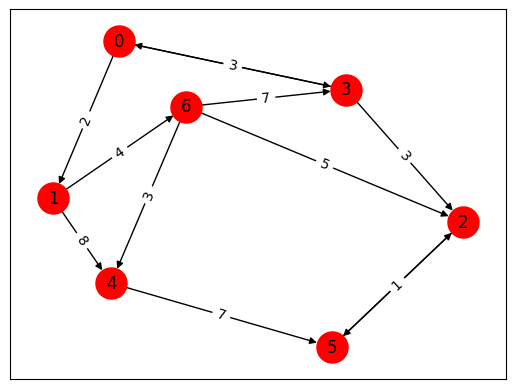

In [11]:
gb.viz.draw(A)

### Bellman–Ford

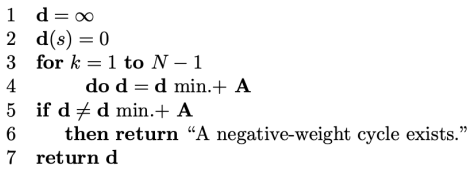

In [3]:
def bellman_ford(A, s):
    n = A.nrows
    v = Vector(A.dtype, n)
    v[s] << 0
    w = v.dup()
    while True:
        w_old = w.dup()
        w(binary.min) << w.vxm(A, semiring.min_plus)
        if w.isequal(w_old):
            break
    for i in range(n):
        if w[i].value is None:
            w[i] = float('inf')
    indices, values = w.to_coo()
    return values

bellman_ford(A, 1)

array([14,  0,  9, 11,  7, 10,  4], dtype=int64)

Функция возвращает массив, где для каждой вершины указано расстояние до неё от указанной стартовой вершины. Если вершина не достижима или кратчайшего пути для неё не существует, то значение соответствующей ячейки равно float('inf').

### Модифицированный Bellman–Ford (несколько стартовых вершин)

In [4]:
def bellman_ford_modified(A, s):
    n = A.nrows
    m = len(s)
    v = Matrix(dtypes.INT32, nrows=m, ncols=n)
    v.build(list(range(m)), s, [0] * m)
    w = v.dup()
    while True:
        w_old = w.dup()
        w(binary.min) << w.mxm(A, semiring.min_plus)
        if w.isequal(w_old):
            break
    for i in range(m):
        for j in range(n):
            if w[i,j].value is None:
                w[i,j] = float('inf')
    rows, cols, values = w.to_coo()
    result = []
    for i in range(w.nrows):
        row_data = [(col, val) for r, col, val in zip(rows, cols, values) if r == i]
        result.append((i, row_data))
    return result

bellman_ford_modified(A, [0,1])

[(0, [(0, 0), (1, 2), (2, 6), (3, 3), (4, 9), (5, 7), (6, 6)]),
 (1, [(0, 14), (1, 0), (2, 9), (3, 11), (4, 7), (5, 10), (6, 4)])]

Функция возвращает массив пар: вершина, и массив, где для каждой вершины указано расстояние до неё из указанной. 

### Floyd–Warshall

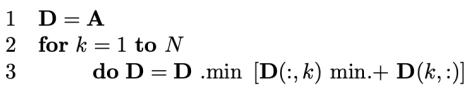

In [5]:
def floyd_warshall(A):

    D = A.dup()
    num_vertices = D.nrows

    for k in range(num_vertices):
        
        D_col = Matrix(dtypes.INT32, nrows=num_vertices, ncols=num_vertices)
        D_row = Matrix(dtypes.INT32, nrows=num_vertices, ncols=num_vertices)
        D_col[:, k] << D[:, k]
        D_row[k, :] << D[k, :]

        D << D.ewise_add(D_col.mxm(D_row, semiring.min_plus), gb.binary.min)

    for i in range(D.nrows):
        for j in range(D.ncols):
            if D[i,j].value is None:
                D[i,j] = float('inf')

    for i in range(num_vertices):
        D[i, i] = 0
    
    rows, cols, values = D.to_coo()
    result = []
    for i in range(D.nrows):
        row_data = [(col, val) for r, col, val in zip(rows, cols, values) if r == i]
        result.append((i, row_data))
    return result

floyd_warshall(A)

[(0, [(0, 0), (1, 2), (2, 6), (3, 3), (4, 9), (5, 7), (6, 6)]),
 (1, [(0, 14), (1, 0), (2, 9), (3, 11), (4, 7), (5, 10), (6, 4)]),
 (2,
  [(0, 9223372036854775807),
   (1, 9223372036854775807),
   (2, 0),
   (3, 9223372036854775807),
   (4, 9223372036854775807),
   (5, 1),
   (6, 9223372036854775807)]),
 (3, [(0, 3), (1, 5), (2, 3), (3, 0), (4, 12), (5, 4), (6, 9)]),
 (4,
  [(0, 9223372036854775807),
   (1, 9223372036854775807),
   (2, 8),
   (3, 9223372036854775807),
   (4, 0),
   (5, 7),
   (6, 9223372036854775807)]),
 (5,
  [(0, 9223372036854775807),
   (1, 9223372036854775807),
   (2, 1),
   (3, 9223372036854775807),
   (4, 9223372036854775807),
   (5, 0),
   (6, 9223372036854775807)]),
 (6, [(0, 10), (1, 12), (2, 5), (3, 7), (4, 3), (5, 6), (6, 0)])]

### Вычисление транзитивного замыкания

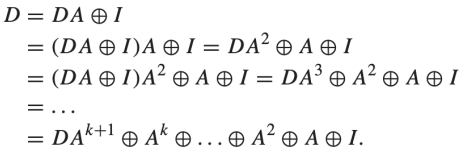

In [7]:
def transitive_closure(A):
    n = A.nrows

    I = Matrix(dtypes.INT64, nrows=n, ncols=n)
    for i in range(n):
        I[i, i] << 1

    D = I.dup()

    for _ in range(n):
        D << D.mxm(A, semiring.min_plus).ewise_add(I, binary.min)

    for i in range(n):
        for j in range(n):
            if not D[i,j].value:
                D[i,j] = float('inf')
    
    rows, cols, values = D.to_coo()
    result = []
    for i in range(D.nrows):
        row_data = [(col, val if val == 9223372036854775807 else val-1) for r, col, val in zip(rows, cols, values) if r == i]
        result.append((i, row_data))

    return result

transitive_closure(A)

[(0, [(0, 0), (1, 2), (2, 6), (3, 3), (4, 9), (5, 7), (6, 6)]),
 (1, [(0, 14), (1, 0), (2, 9), (3, 11), (4, 7), (5, 10), (6, 4)]),
 (2,
  [(0, 9223372036854775807),
   (1, 9223372036854775807),
   (2, 0),
   (3, 9223372036854775807),
   (4, 9223372036854775807),
   (5, 1),
   (6, 9223372036854775807)]),
 (3, [(0, 3), (1, 5), (2, 3), (3, 0), (4, 12), (5, 4), (6, 9)]),
 (4,
  [(0, 9223372036854775807),
   (1, 9223372036854775807),
   (2, 8),
   (3, 9223372036854775807),
   (4, 0),
   (5, 7),
   (6, 9223372036854775807)]),
 (5,
  [(0, 9223372036854775807),
   (1, 9223372036854775807),
   (2, 1),
   (3, 9223372036854775807),
   (4, 9223372036854775807),
   (5, 0),
   (6, 9223372036854775807)]),
 (6, [(0, 10), (1, 12), (2, 5), (3, 7), (4, 3), (5, 6), (6, 0)])]

In [10]:
answer1 = np.array([14, 0, 9, 11, 7, 10, 4], dtype=np.int64)
answer2 = [
    (0, [(0, 0), (1, 2), (2, 6), (3, 3), (4, 9), (5, 7), (6, 6)]),
    (1, [(0, 14), (1, 0), (2, 9), (3, 11), (4, 7), (5, 10), (6, 4)])
]
answer3 = [(0, [(0, 0), (1, 2), (2, 6), (3, 3), (4, 9), (5, 7), (6, 6)]),
 (1, [(0, 14), (1, 0), (2, 9), (3, 11), (4, 7), (5, 10), (6, 4)]),
 (2, [(0, 9223372036854775807), (1, 9223372036854775807), (2, 0), (3, 9223372036854775807), (4, 9223372036854775807), (5, 1), (6, 9223372036854775807)]),
 (3, [(0, 3), (1, 5), (2, 3), (3, 0), (4, 12), (5, 4), (6, 9)]),
 (4, [(0, 9223372036854775807), (1, 9223372036854775807), (2, 8), (3, 9223372036854775807), (4, 0), (5, 7), (6, 9223372036854775807)]),
 (5, [(0, 9223372036854775807), (1, 9223372036854775807), (2, 1), (3, 9223372036854775807), (4, 9223372036854775807), (5, 0), (6, 9223372036854775807)]),
 (6, [(0, 10), (1, 12), (2, 5), (3, 7), (4, 3), (5, 6), (6, 0)])]

assert (bellman_ford(A, 1) == answer1).all()
assert (bellman_ford_modified(A, [0,1]) == answer2)
assert (floyd_warshall(A) == answer3)
assert (transitive_closure(A) == answer3)

In [8]:
M1 = mmread('matrices/GD01_b.mtx')
M2 = mmread('matrices/jgl009.mtx')
M3 = mmread('matrices/rgg010.mtx')
M4 = mmread('matrices/Tina_AskCal.mtx')
M5 = mmread('matrices/Trefethen_20.mtx')
M6 = mmread('matrices/Trefethen_20b.mtx')

matrices = [M1, M2, M3, M4, M5, M6]

In [115]:
def algorithm_running_time(matrices):
    i = 1
    for matrix in matrices:
        print('Матрица №', i)
        print('Bellman-Ford:', end=' ')
        %timeit bellman_ford(matrix, 0)
        print('Bellman-Ford modified:', end=' ')
        %timeit bellman_ford_modified(matrix, [0, 1])
        print('Floyd-Warshall:', end=' ')
        %timeit floyd_warshall(matrix)
        print('Transitive Closure:', end=' ')
        %timeit transitive_closure(matrix)
        print()
        i += 1

algorithm_running_time(matrices)

Матрица № 1
Bellman-Ford: 1.49 ms ± 267 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Bellman-Ford modified: 2.57 ms ± 150 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Floyd-Warshall: 120 ms ± 58 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Transitive Closure: 48.1 ms ± 2.48 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

Матрица № 2
Bellman-Ford: 825 µs ± 363 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Bellman-Ford modified: 2.41 ms ± 455 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Floyd-Warshall: 38.8 ms ± 19.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Transitive Closure: 20 ms ± 5.25 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)

Матрица № 3
Bellman-Ford: 945 µs ± 289 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Bellman-Ford modified: 2.25 ms ± 184 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Floyd-Warshall: 36 ms ± 2.9 ms per loop (mean ± std. dev. of 7 runs, 10

Поиск кратчайших путей для одной и двух вершин в обычном и модифицированном Bellman-Ford сильно быстрее поиска для всех вершин в Floyd-Warshall и Transitive Closure. Floyd-Warshall чуть быстрее транзитивного замыкания.

### Зависимость времени работы алгоритмов от размера графа

In [9]:
def generate_random_undirected_graph(num_vertices, sparsity):

    graph = Matrix(dtypes.INT32, num_vertices, num_vertices)

    for i in range(num_vertices):
        for j in range(i + 1, num_vertices):
            if random.random() < sparsity:
                graph[i, j] = 1.0
                graph[j, i] = 1.0

    return graph

Сгенерируем графы с количеством вершин от 5 до 300, степень разреженности одинаковая.

In [15]:
def generate_graphs(node_probs_list):
    return [generate_random_undirected_graph(nodes, prob) for nodes, prob in node_probs_list]

graph_specs = [
    (5, 0.5),
    (10, 0.5),
    (30, 0.5),
    (50, 0.5),
    (100, 0.5),
    (150, 0.5),
    (200, 0.5),
    (250, 0.5),
    (300, 0.5)
]

matrices = generate_graphs(graph_specs)

In [16]:
algorithm_running_time(matrices)

Матрица № 1
Bellman-Ford: 542 µs ± 13.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Bellman-Ford modified: 1.03 ms ± 11.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Floyd-Warshall: 6.92 ms ± 121 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Transitive Closure: 3.19 ms ± 26.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

Матрица № 2
Bellman-Ford: 542 µs ± 5.46 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Bellman-Ford modified: 1.27 ms ± 18.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Floyd-Warshall: 20.5 ms ± 285 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Transitive Closure: 12 ms ± 160 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

Матрица № 3
Bellman-Ford: 603 µs ± 78.3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Bellman-Ford modified: 2.59 ms ± 100 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Floyd-Warshall: 176 ms ± 3.52 ms per loop (mean ± std. dev.

Время работы всех реализаций растет с увеличением количества вершин в графах.

### Зависимость времени работы  от степени разреженности

In [10]:
def generate_graphs(node_probs_list):
    return [generate_random_undirected_graph(nodes, prob) for nodes, prob in node_probs_list]

graph_specs = [
    (50, 0.1),
    (50, 0.2),
    (50, 0.3),
    (50, 0.4),
    (50, 0.5),
    (50, 0.6),
    (50, 0.7),
    (50, 0.8),
    (50, 0.9)
]

matrices = generate_graphs(graph_specs)

In [11]:
algorithm_running_time(matrices)

Матрица № 1
Bellman-Ford: 882 µs ± 67.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Bellman-Ford modified: 14.4 ms ± 252 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Floyd-Warshall: 631 ms ± 3.96 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Transitive Closure: 588 ms ± 1.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Матрица № 2
Bellman-Ford: 694 µs ± 787 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Bellman-Ford modified: 14.4 ms ± 339 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Floyd-Warshall: 633 ms ± 9.15 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Transitive Closure: 591 ms ± 6.43 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Матрица № 3
Bellman-Ford: 566 µs ± 2.97 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Bellman-Ford modified: 14.1 ms ± 192 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Floyd-Warshall: 627 ms ± 3.44 ms per loop (mean ± std. dev. of 7 runs, 1 loop

Bellman-Ford modified, Floyd-Warshall и Transitive Closure практически не зависят, для Bellman-Ford наблюдается небольшое снижение времени с уменьшением разреженности.

### Выбор количества вершин для поиска в модифицированном Bellman-Ford

In [15]:
def algorithm_running_time(matrix):
    s = [0]
    i = 1
    while i < 102:
        print('Количество стартовых вершин для Bellman-Ford =', len(s))
        print('Bellman-Ford modified:', end=' ')
        %timeit bellman_ford_modified(matrix, s)
        print('Floyd-Warshall:', end=' ')
        %timeit floyd_warshall(matrix)
        print('Transitive Closure:', end=' ')
        %timeit transitive_closure(matrix)
        print()
        for _ in range(10):
            s.append(i)
            i += 1

In [16]:
graph_specs = [ (101, 0.5) ]

matrix = generate_graphs(graph_specs)[0]

algorithm_running_time(matrix)

Количество стартовых вершин для Bellman-Ford = 1
Bellman-Ford modified: 3.66 ms ± 92.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Floyd-Warshall: 4.2 s ± 72.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Transitive Closure: 4.26 s ± 16.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество стартовых вершин для Bellman-Ford = 11
Bellman-Ford modified: 71.4 ms ± 911 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Floyd-Warshall: 4.17 s ± 21.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Transitive Closure: 4.27 s ± 28.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество стартовых вершин для Bellman-Ford = 21
Bellman-Ford modified: 212 ms ± 6.73 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Floyd-Warshall: 4.21 s ± 62.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Transitive Closure: 4.25 s ± 8.68 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество стартовых вершин для Bellman-Ford = 31
Bell

Для графа со 101 вершиной Bellman-Ford показывает более высокую скорость по сравнению с Floyd-Warshall и Transitive Closure, даже если выбраны вообще все вершины.

### push/pull direction optimization

In [32]:
def bellman_ford_push_pull(A, s, push_pull_percent):
    v = Vector(A.dtype, A.nrows)
    v[s] << 0
    w = v.dup()
    
    while True:
        w_old = w.dup()
        # push
        if push_pull_percent == 0.0:
            w(binary.min) << w.vxm(A, semiring.min_plus)
        # pull
        elif push_pull_percent == 1.0:
            w(binary.min) << A.T.mxv(w, semiring.min_plus)
        # порог наполненности
        else:
            if w.nvals / w.size > push_pull_percent:
                w(binary.min) << A.T.mxv(w, semiring.min_plus)
            else:
                w(binary.min) << w.vxm(A, semiring.min_plus)
        
        if w.isequal(w_old):
            break
            
    indices, values = w.to_coo()
    return values

In [34]:
graph_specs = [ (1000, 0.5) ]
matrix = generate_graphs(graph_specs)[0]

for i in [0.0, 0.1, 0.3, 0.7, 1.0]:
    print('push/pull =', i)
    %timeit bellman_ford_push_pull(matrix, 4, i)
    print()

push/pull = 0.0
6.75 ms ± 175 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

push/pull = 0.1
6.8 ms ± 274 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

push/pull = 0.3
6.78 ms ± 147 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

push/pull = 0.7
6.71 ms ± 128 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

push/pull = 1.0
6.73 ms ± 155 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)



Для алгоритма Bellman-Ford использование различных стратегий (всегда push, всегда pull, использовать порог наполненности вектора) не сильно повлияло на скорость его работы.